In [1]:
import gym
import numpy as np
import random
import torch
from itertools import count


In [2]:
env = gym.make('MountainCarContinuous-v0')

In [3]:
env.action_space

Box(1,)

In [4]:
env.observation_space

Box(2,)

In [5]:
env.reset()
env.render()

True

In [6]:
env.close()
env.reset()

array([-0.50980259,  0.        ])

In [8]:
from time import sleep

for i in range(50):
    env.step(env.action_space.sample())
    env.render()
    sleep(0.01)
env.close()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [10]:
class Memory():
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.memory = []
        self.short_memory = []
        
    def push(self, old_state, action, reward, new_state, final):
        self.short_memory.append([old_state, action, reward, new_state, final])
        
    def commit(self, final=True): 
        
#         R = self.short_memory[-1][2]
#         for i in range(len(self.short_memory) - 1):
#             R = self.short_memory[-2 -i][2] + R*0.99
#             self.short_memory[-2 -i][2] = R
        
        if len(self.memory) + len(self.short_memory) < self.capacity:
            self.memory.extend(self.short_memory)
        else:
            for memo in self.short_memory:
                self.memory.insert(random.randint(0, len(self.memory) - 1), memo)
                
        self.memory = self.memory[:self.capacity]
        self.short_memory = []

In [35]:
class Actor_net(torch.nn.Module):
    def __init__(self):
        super(Actor_net, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )
    
    def forward(self, x):
        return self.model(x)
    
class Qritic_net(torch.nn.Module):
    def __init__(self):
        super(Qritic_net, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
#             torch.nn.LeakyReLU(inplace=True),
#             torch.nn.Linear(32, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.LeakyReLU(),
        )
        
        self.head = torch.nn.Sequential(
            torch.nn.Linear(64 + 1, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 1),
        )
    
    def forward(self, state, actions):
        out = self.model(state)
        out = torch.cat((out, actions), dim=1)
        out = self.head(out)
        return out

policy_actor, policy_critic = Actor_net().to(device), Qritic_net().to(device)
target_actor, target_critic = Actor_net().to(device), Qritic_net().to(device)

target_actor.load_state_dict(policy_actor.state_dict())
target_critic.load_state_dict(policy_critic.state_dict())

critic_optim = torch.optim.Adam(policy_critic.parameters(), lr=0.01)
actor_optim = torch.optim.Adam(policy_actor.parameters(), lr=0.01)
# optim = torch.optim.SGD(policy_net.parameters(), lr=0.001)

# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optim, step_size=100, gamma=0.84)    

In [44]:
# env = gym.make('CartPole-v0')
# env._max_episode_steps = 500

EPS = 0.999
EPS_MIN = 0.05
GAMMA = 0.999999


def get_model_action(model, state, device, train=True):
    global EPS, EPS_MIN, GAMMA
    EPS = EPS * GAMMA
    EPS = max(EPS, EPS_MIN)
    
    with torch.no_grad():
        model_output = model(torch.FloatTensor(state).to(device).unsqueeze(0)).cpu().detach().numpy()
        action = model_output[0]
#             print(state, model_output, action)
            
    if train:
        noise = (random.random() * 2) -1
        noise = noise * EPS * 2.5
        action = action + noise
        action = np.clip(action, -1, 1)
        
        
    return action

def train(memory, device):
    memory = memory.memory
    try:
        memory = random.sample(memory, 128)
    except ValueError:
        return

    s0 = [x[0] for x in memory]
    a = [x[1] for x in memory]
    r = [[x[2]] for x in memory]
    s1 = [x[3] for x in memory]
    done = [1. if x[4] else 0. for x in memory]


    s0 = torch.FloatTensor(s0).to(device)
    s1 = torch.FloatTensor(s1).to(device)
    a = torch.FloatTensor(a).to(device)
    r = torch.FloatTensor(r).to(device)
    done = torch.FloatTensor(done).to(device)

    
    y = target_critic(s1, target_actor(s1)).mul(0.99).add(r)
    target = policy_critic(s0, a)
#     loss = (y.detach() - target).view(-1).pow(2).mean()
    loss = torch.nn.functional.smooth_l1_loss(y.detach(), target)
    
#     print('s0', s0)
#     print('a', a)
#     print('r', r)
#     print('s1', s1)
    
#     print('y', y)
#     print('target', target)
#     print('loss', loss.item())
#     assert False
    
    critic_optim.zero_grad()
    torch.nn.utils.clip_grad_norm_(policy_critic.parameters(), 1)
    loss.backward()
    critic_optim.step()
    
    policy_actions = policy_actor(s0)
    q_values = policy_critic(s0, policy_actions)
    
    loss = q_values.mean().mul(-1)
    actor_optim.zero_grad()
    loss.backward()
    actor_optim.step()
    
#     print('policy_actions', policy_actions)
#     print('q_values', q_values)
#     print('loss', loss.item())
#     assert False
    
    def soft_update(target_model, local_model, tau=0.1):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
                
    soft_update(target_actor, policy_actor)
    soft_update(target_critic, policy_critic)
        
#     scheduler.step()

memory = Memory(capacity=100000)  
len_mem = []
cum_reward_mem = []

try:
    for episode in range(100000):
        state = env.reset()

        cum_reward = []
        for i in count():
#             env.render()

            action = get_model_action(policy_actor, state, device)
            old_state = state
            state, reward, done, info = env.step(action)
            
#             reward = max(-0.1, state[0])
#             reward *= 100

            cum_reward.append(reward)

            
            if not done:
                memory.push(old_state, action, reward, state, False)
            else:
                env.close()
                len_mem.append(i)
                cum_reward_mem.append(np.sum(cum_reward))

#                 if state[0] >= 0.59:
#                     reward = 100
#                     final = False
#                 else:
#                     final = True
                
                memory.push(old_state, action, reward, state, True)
                memory.commit()
                break

        
        if episode % 10 == 0:
            print('Episode {:3d}: {:10.3f} iterations, eps={:6.6f}'.format(episode, np.mean(len_mem[-100:]), EPS))
        
        train(memory, device)

except KeyboardInterrupt:
    env.close()

Episode   0:    199.000 iterations, eps=0.998800
Episode  10:    199.000 iterations, eps=0.996805


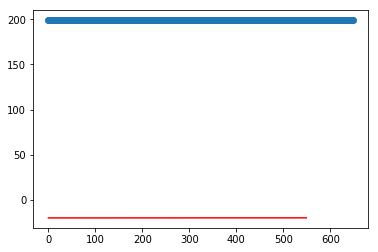

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd


plt.figure()
plt.plot(len_mem, 'o')
plt.plot(pd.Series(cum_reward_mem).rolling(100).mean().dropna().values, color='red')

In [27]:
try:
#     env.seed = random.randint(0, 100000)
    obs = env.reset()
    env._max_episode_steps = 200
    for t in count():
        
        if t % 500 == 0:
            print(t)
        
        env.render()
        global EPS
        EPS = 0.95
        action = get_model_action(policy_actor, obs, device, train=False)
        obs, reward, done, info = env.step(action)
        print(action, reward)
        if done:
            env.close()
            break

    print(t)
except KeyboardInterrupt:
    pass
finally:
    env.close()
    print(t)

0
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.1
[1.] -0.

In [20]:
model = policy_net

In [21]:
model.to('cpu')

Qnet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [22]:
torch.save(model, 'cart.torch')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Qnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [23]:
model = torch.load('cart.torch')

In [24]:
model.to(device)

Qnet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [25]:
policy_net = model